In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob

In [4]:
testData = xr.open_dataset(f'{amon_path}/psl_Amon_MPI-ESM1-2-HR_piControl_r1i1p1f1_gn_185001-185412.nc')

In [15]:
amon_path = '/scratch/groups/earlew/yuchen/cmip6/piControl/Amon'

def calculate_sam(model_name):
    # Get list of files for the model
    files = sorted(glob.glob(f"{amon_path}/psl_Amon_{model_name}_piControl_*.nc"))
    
    # Concatenate files along time dimension
    ds = xr.open_mfdataset(files, combine='by_coords', use_cftime=True)
    
    # Calculate annual means
    ds_annual = ds.resample(time='AS').mean()
    
    # Calculate zonal mean at 40S and 65S
    ds_zonal_40S = ds_annual.sel(lat=-40, method="nearest").mean(dim='lon')
    ds_zonal_65S = ds_annual.sel(lat=-65, method="nearest").mean(dim='lon')
    
    # Calculate SAM index
    sam = ds_zonal_40S['psl'] - ds_zonal_65S['psl']
    
    return sam


In [23]:
models = ['MPI-ESM1-2-LR']
sam_dict = {}
for model in models:
    sam_dict[model] = calculate_sam(model)


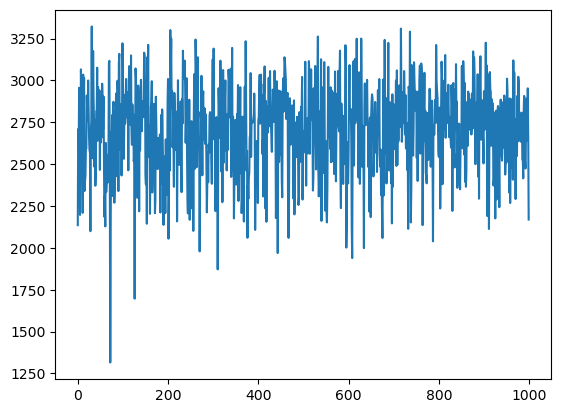

In [24]:
plt.plot(sam_dict['MPI-ESM1-2-LR'].values)

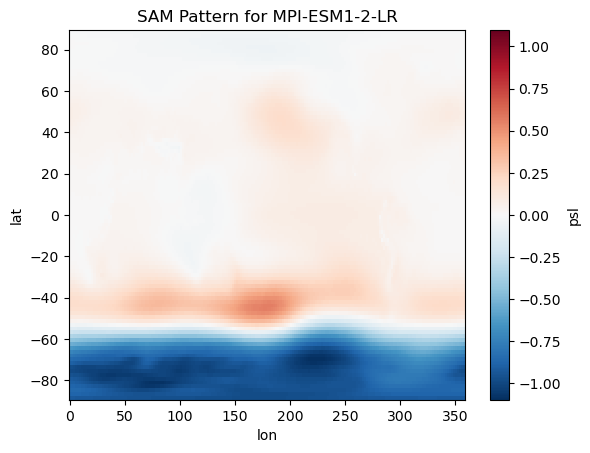

In [35]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

def regress_sam(model_name, sam):
    # Get list of files for the model
    files = sorted(glob.glob(f"/scratch/groups/earlew/yuchen/cmip6/piControl/Amon/psl_Amon_{model_name}_piControl_*.nc"))

    # Concatenate files along time dimension
    ds = xr.open_mfdataset(files, combine='by_coords', use_cftime=True)

    # Calculate annual means
    ds_annual = ds.resample(time='AS').mean()

    # Function to apply linear regression
    def linear_regression(y, x):
        slope, _, _, _, _ = linregress(x, y)
        return slope

    # Prepare for apply_ufunc: move 'time' dimension to the end
    ds_annual = ds_annual.transpose("lat", "lon", "bnds", "time")
    sam_broad = xr.broadcast(sam, ds_annual['psl'])[0]

    # Apply the linear regression to psl over the 'time' dimension
    slope = xr.apply_ufunc(linear_regression, ds_annual['psl'].load(), sam_broad.load(),
                           input_core_dims=[['time'], ['time']],
                           vectorize=True)  # Apply to each element

    # Plot
    slope.plot()
    plt.title(f"SAM Pattern for {model_name}")
    plt.show()


for model in models:
    regress_sam(model, sam_dict[model])
